<a href="https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/part3_groups_spatial_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MATOPIBA emissions profile code 
**Part 3: Spatial relationship of groups**

Links for all code:
* [Part 1: Groups identification](https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/part1_groups_identification.ipynb#scrollTo=fmLf4ECyHt3F)
* [Part 2: Interpretation of groups to identify the emissions profile](https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/part2_groups_profile.ipynb)
* [Part 3: Spatial relationship of groups](https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/part3_groups_spatial_.ipynb)


In [1]:
!pip install pysal
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Installing all libraries used for analysis
import numpy as np
import pandas as pd


# #Installing all libraries used for visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Spatial libraries
import geopandas as gpd
import folium

#PySAL libraries
from libpysal.weights.contiguity import Queen
from esda.moran import Moran, Moran_Local, Moran_BV, Moran_Local_BV
from splot.esda import moran_scatterplot, plot_local_autocorrelation, lisa_cluster, plot_moran_bv

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
!git clone https://github.com/tbrugz/geodata-br.git

fatal: destination path 'geodata-br' already exists and is not an empty directory.


In [4]:
#Collecting the Matopiba Emissions Data
!git clone https://github.com/lucas-fpaiva/matopiba_emissions.git

fatal: destination path 'matopiba_emissions' already exists and is not an empty directory.


## Spatial distribution of groups

In [5]:
df_graf = pd.read_csv("/content/matopiba_emissions/data/matopiba_groups.csv")
df_graf= df_graf[['States', 'Municipalities', 'emi_2018','group_name','group','pib_2018','population','Agriculture','LUC','Energy','Waste']]
df_graf['ID']=df_graf["Municipalities"]+df_graf['States']
df_graf.head()

,States,Municipalities,emi_2018,group_name,group,pib_2018,population,Agriculture,LUC,Energy,Waste,ID
0,TO,Abreulândia,415469.12,G1,1,52402.19,2564,0.307672,0.689238,0.001277,0.001814,AbreulândiaTO
1,MA,Açailândia,2012738.15,G1,1,2602790.66,111757,0.348744,0.513556,0.110196,0.027504,AçailândiaMA
2,MA,Afonso Cunha,77780.74,G5,5,50235.77,6468,0.094138,0.758761,0.129712,0.017389,Afonso CunhaMA
3,MA,Água Doce do Maranhão,28598.70,G1,1,86186.06,12488,0.244302,0.530653,0.137829,0.087216,Água Doce do MaranhãoMA
4,TO,Aguiarnópolis,116760.47,G3,3,124903.42,6571,0.177852,0.271308,0.534922,0.015919,AguiarnópolisTO


In [6]:
df_loc = pd.read_csv('/content/matopiba_emissions/data/municipalities_loc.csv',error_bad_lines=False,encoding='latin-1')
df_loc = df_loc.loc[df_loc['codigo_uf'].isin([17,21,22,29])]
df_loc['codigo_uf'] = df_loc['codigo_uf'].map({17:'TO',
                             21:'MA',
                             22:'PI',
                             29:'BA'},
                             na_action=None)
df_loc.rename(columns={"nome":"CIDADES",'codigo_uf':'ESTADOS','latitude':'lat','longitude':'long','codigo_ibge':'ibge_code'}, inplace=True)
df_loc['ID'] = df_loc["CIDADES"]+df_loc['ESTADOS']

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df_loc.head()

,ibge_code,CIDADES,lat,long,capital,ESTADOS,siafi_id,ddd,fuso_horario,ID
6,2900108,Abaíra,-13.24880,-41.6619,0,BA,3301,77,America/Sao_Paulo,AbaíraBA
7,2900207,Abaré,-8.72073,-39.1162,0,BA,3303,75,America/Sao_Paulo,AbaréBA
14,1700251,Abreulândia,-9.62101,-49.1518,0,TO,337,63,America/Sao_Paulo,AbreulândiaTO
16,2100055,Açailândia,-4.94714,-47.5004,0,MA,961,99,America/Sao_Paulo,AçailândiaMA
17,2900306,Acajutiba,-11.65750,-38.0197,0,BA,3305,75,America/Sao_Paulo,AcajutibaBA


In [8]:
df_graf=df_graf.merge(df_loc[['ID','lat','long','ibge_code']],on='ID')

In [9]:
df_graf.count()

States            337
Municipalities    337
emi_2018          337
group_name        337
group             337
pib_2018          337
population        337
Agriculture       337
LUC               337
Energy            337
Waste             337
ID                337
lat               337
long              337
ibge_code         337
dtype: int64

### Interactive map

In [10]:
map = folium.Map(location=[df_graf.lat.mean(), df_graf.long.mean()], zoom_start=5, control_scale=True)
correct_html_color = ['#606060','#0000A5','#00AAA0','#00F900','#D70000','#FFCE0A']

for i in range(0,df_graf.shape[0]):

    color = correct_html_color[df_graf.group[i]-1]
    folium.CircleMarker([df_graf.lat[i],
                   df_graf.long[i]],
                       radius=5,
                color=color,
                fill=True,
                fill_color=color,
                popup=str('<i>' +df_graf.Municipalities[i]+ ':' +df_graf.group_name[i]+ '('+str(df_graf.lat[i])+'-'+str(df_graf.long[i])+')'+'</i>')
                  ).add_to(map)

map

In [11]:
map.save('/content/map_matopiba.html')

### Adding and plotting the areas of municipalities

In [12]:
df_geo = gpd.read_file('/content/geodata-br/geojson/geojs-100-mun.json')
df_geo.rename(columns={'id':'ibge_code'},inplace=True)
df_geo['ibge_code'] = df_geo['ibge_code'].astype(int)
df_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5564 entries, 0 to 5563
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ibge_code    5564 non-null   int64   
 1   name         5564 non-null   object  
 2   description  5564 non-null   object  
 3   geometry     5564 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 174.0+ KB


In [13]:
df_graf = df_graf.merge(df_geo,on='ibge_code')

In [14]:
data_graph=df_graf.copy()
data_graph.rename(columns={'ibge_code':'id'},inplace=True)
data_graph['id']=data_graph['id'].astype(str)

In [15]:
correct_color = [(0.3764705882352941, 0.3764705882352941, 0.3764705882352941, 1),
                 (0, 0, 0.6470588235294118, 1),
                 (0, 0.6666666666666666, 0.6274509803921569, 1),
                 (0, 0.9764705882352941, 0, 1),
                 (0.8431372549019608, 0, 0, 1),
                 (1.0, 0.807843137254902, 0.0392156862745098, 1),
                 (0.1, 0.1, 0.1, 1)]

In [16]:
data_map = gpd.read_file('/content/geodata-br/geojson/geojs-100-mun.json')
data_test = data_graph[['group','id','group_name','lat','long',"States",'emi_2018',"Agriculture","LUC","Energy","Waste"]]
data_map=data_map.merge(data_test,on='id')


In [17]:
xm = [data_map['lat'].min(), data_map['lat'].max()]
ym = [data_map['long'].min(), data_map['long'].max()]

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' o

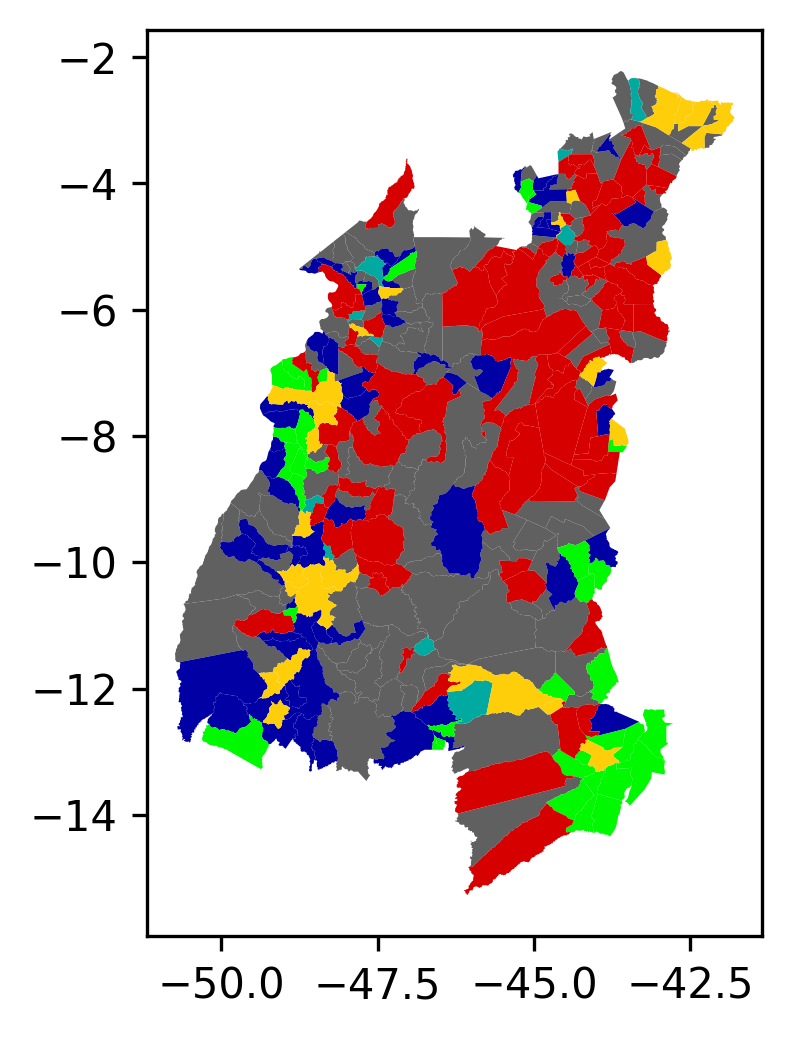

In [18]:
fig, ax = plt.subplots(1, 1,dpi=300)

for i in range(1,7):

  data_map[data_map.group==i].plot(column='group',color=correct_color[i-1],ax=ax,legend=True)

  
  plt.savefig("/content/matopiba_emissions/output/map_group.pdf", format="pdf", dpi=1000)  

## Morgan's analysis

In [19]:
weights = Queen.from_dataframe(data_map);
W_matrix, ids = weights.full();
weights.transform = 'r';
W_matrix, ids = weights.full();

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


### Univariate

In [20]:
def moran_plots(data_map,setor):

  y = data_map[setor].copy()
  moran = Moran(y, weights)

  moran_loc = Moran_Local(y, weights)

  print('\n----------------------'+setor+'-------------------------')

  plot_local_autocorrelation(moran_loc, data_map, setor)
  plt.show()
  
  print('Evaluating the significance:')
  print('Moran:',moran.I)
  print("P-value",moran.p_sim)

In [21]:
def lisa_plots(data_map,sector):

  y = data_map[sector].copy()
  moran = Moran(y, weights)
  moran_loc = Moran_Local(y, weights)

  lisa,_=lisa_cluster(moran_loc, data_map, p=0.05, figsize=(8,10)) #
  lisa.text(.3,.83, sector+' sector',size=15)
  lisa.text(.3,.80, "Global Moran's I: "+str(round(moran.I,3)),size=14)
  lisa.text(.3,.78, "P-value: "+str(round(moran.p_sim,4)),size=14)
  plt.show()
  lisa.savefig("/content/matopiba_emissions/output/moran_"+sector+".pdf", format="pdf", dpi=1000)

  print(moran.EI_sim)
  print(moran.p_sim)
#https://pysal.org/esda/generated/esda.Moran.html


#### Analyzing from the centers of the clusters in each axis (sector)

In [22]:
centers = np.load('/content/matopiba_emissions/data/clusters_centers.npy')

C_features=["C_Agriculture","C_LUC","C_Energy","C_Waste"]
C=[]
for group in data_map.group:
  for i in range(1,7):
    if group ==i:
      C.append(centers[group-1])
      # print(centers[group-1],i)
  
C=np.array(C)

for j in range(0,4):
  data_map[C_features[j]] = C[:,j]


----------------------C_Agriculture-------------------------


/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


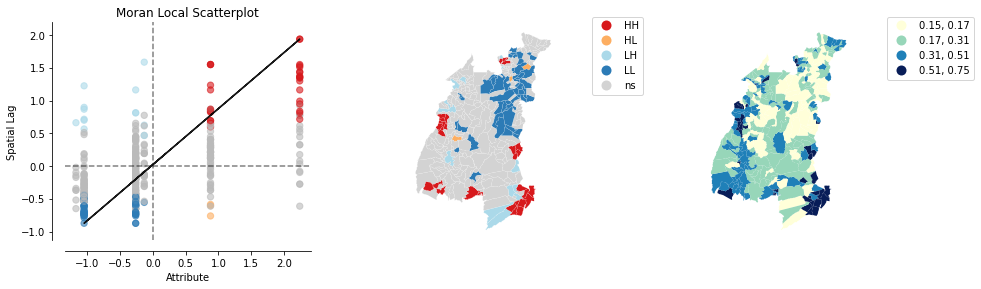

Evaluating the significance:
Moran: 0.3860706713468157
P-value 0.001

----------------------C_LUC-------------------------


/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


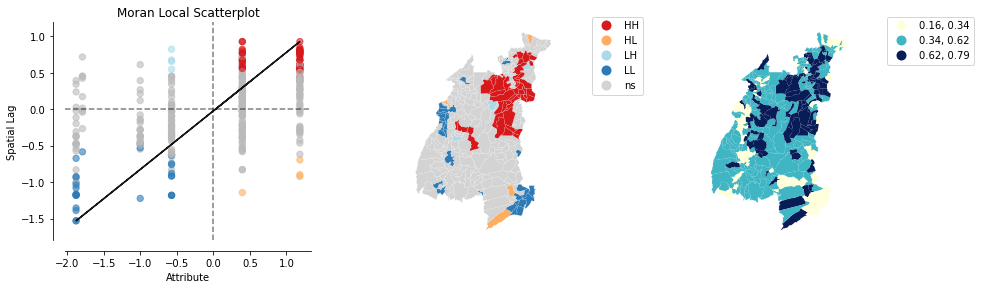

Evaluating the significance:
Moran: 0.3474054870497591
P-value 0.001

----------------------C_Energy-------------------------


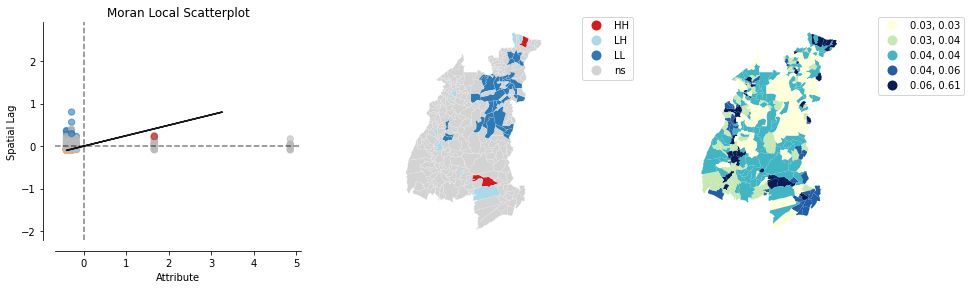

Evaluating the significance:
Moran: 0.05877143754265175
P-value 0.054

----------------------C_Waste-------------------------


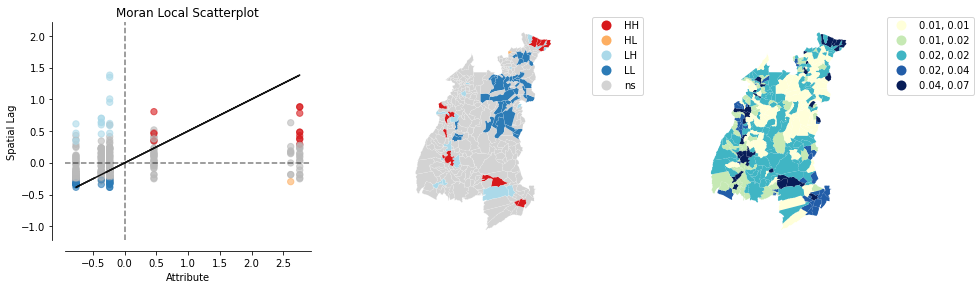

Evaluating the significance:
Moran: 0.16784463537563948
P-value 0.001


In [23]:
for sector in C_features:
  moran_plots(data_map,sector)

#### Analyze from the contributions of each sector to the emissions of each city


----------------------Agriculture-------------------------


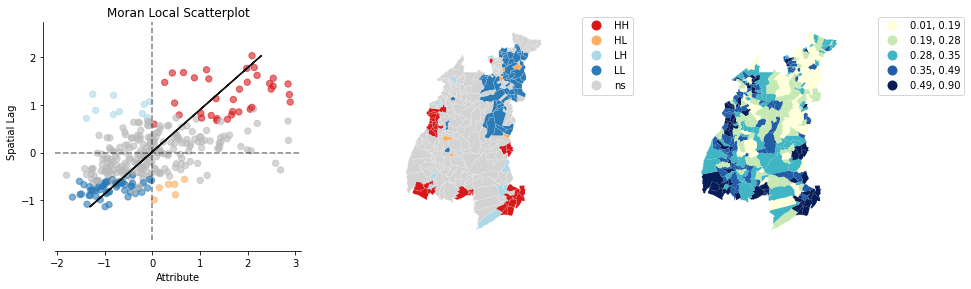

Evaluating the significance:
Moran: 0.44609810005126926
P-value 0.001

----------------------LUC-------------------------


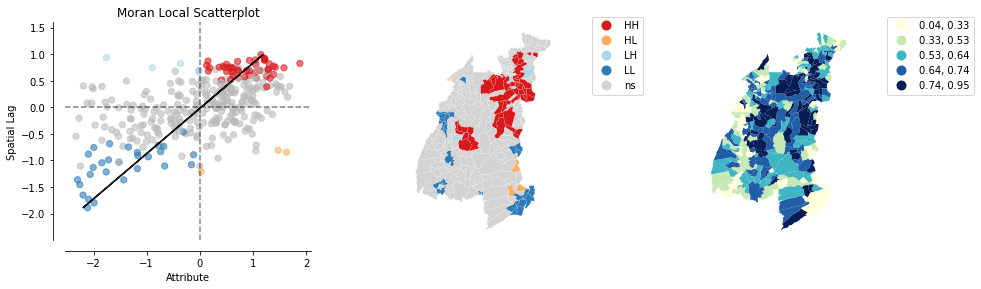

Evaluating the significance:
Moran: 0.37134134597635277
P-value 0.001

----------------------Energy-------------------------


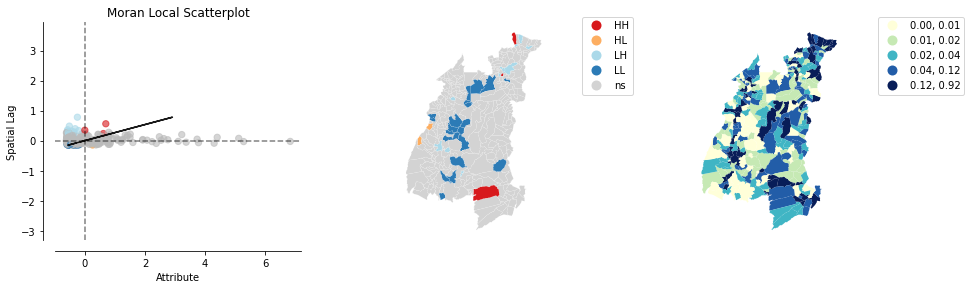

Evaluating the significance:
Moran: 0.0588307193699729
P-value 0.053

----------------------Waste-------------------------


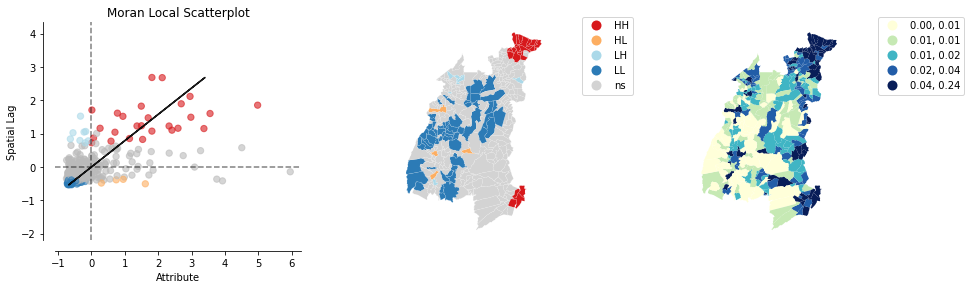

Evaluating the significance:
Moran: 0.37662283173761063
P-value 0.001


In [24]:
features=["Agriculture","LUC","Energy","Waste"]
for sector in features:
  moran_plots(data_map,sector)

Save figures for paper

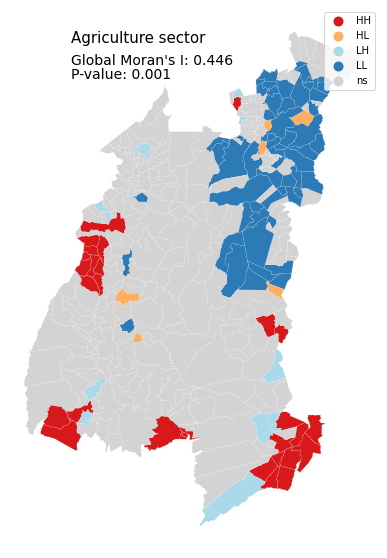

-0.001704499253779765
0.001


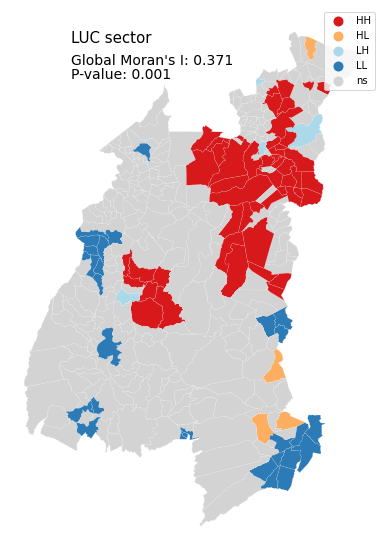

-0.002860763859893275
0.001


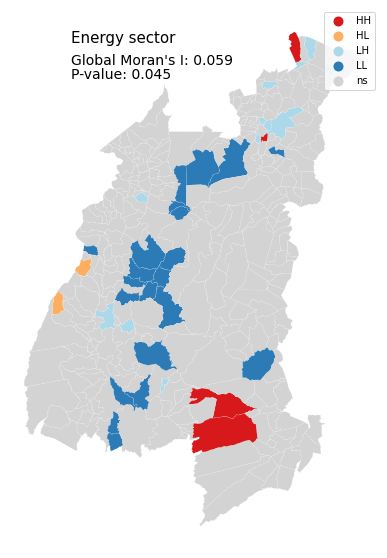

-0.004974481483445181
0.045


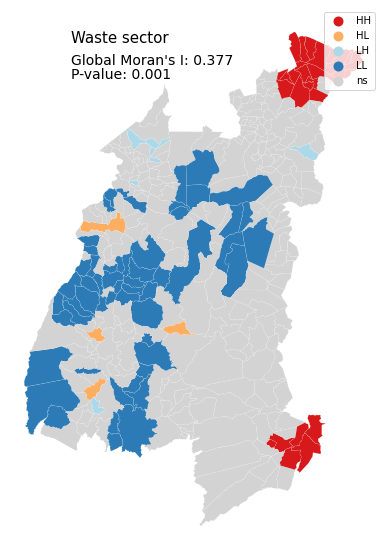

-0.003186051110763124
0.001


In [25]:
for sector in features:
  lisa_plots(data_map,sector)

### Bivariate LUC *vs* Agriculture

#### From clusters centers

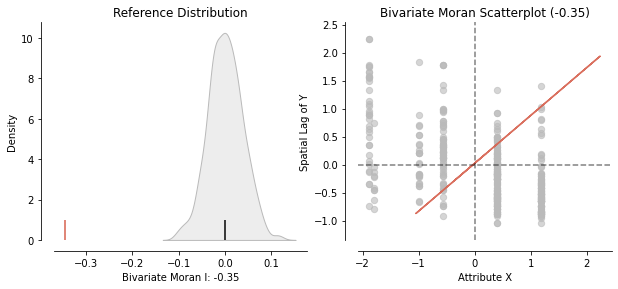

In [26]:
x = data_map['C_Agriculture'].values
y = data_map['C_LUC'].values

moran_bv = Moran_BV(y, x, weights)
moran_loc_bv = Moran_Local_BV(y, x,weights)

moran_bv.I

plot_moran_bv(moran_bv)
plt.show()

/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


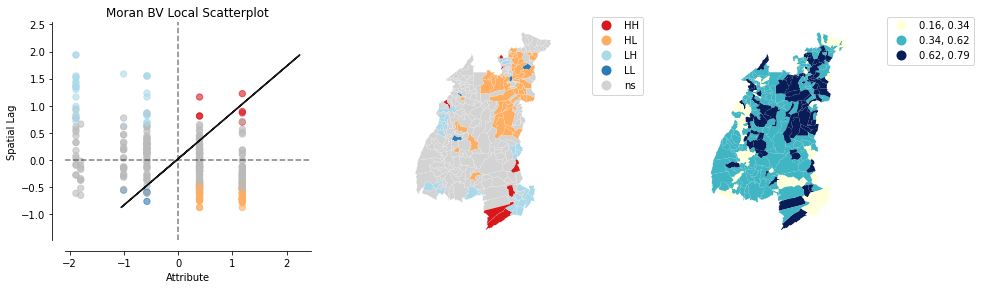

In [27]:
fig = plot_local_autocorrelation(moran_loc_bv, data_map, 'C_LUC')

plt.xlabel('Agriculture')
plt.ylabel('Spatial lag of LUC contributions')
plt.show()

#### From sector's emisson contribution

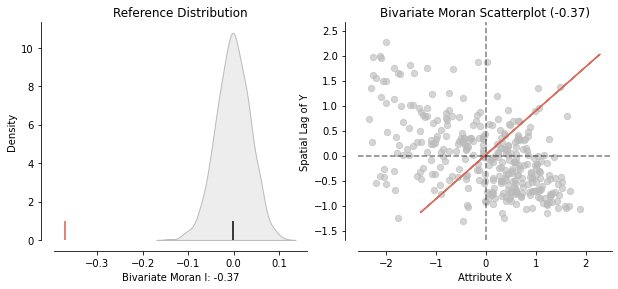

In [28]:
x = data_map['Agriculture'].values
y = data_map['LUC'].values

moran_bv = Moran_BV(y, x, weights)
moran_loc_bv = Moran_Local_BV(y, x, weights)

moran_bv.I

plot_moran_bv(moran_bv)
plt.show()

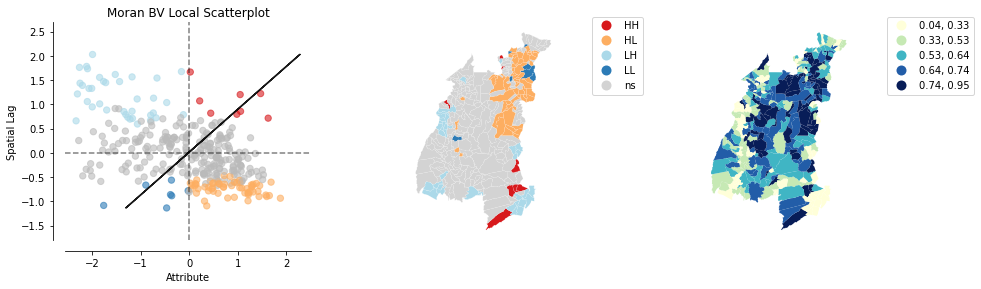

In [29]:
fig = plot_local_autocorrelation(moran_loc_bv, data_map, 'LUC')

plt.xlabel('Agriculture')
plt.ylabel('Spatial lag of LUC contributions')
plt.show()